In [1]:

%matplotlib widget
import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../

import pylib.mix as mix
import pylib.measurement as mse
import est_qsvt as eqsvt

15363
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [3]:
# ----------------------------------------------------------------------
# Compute coefficients for the estimation of the QSVT angles necessary
# for the inversion of a matrix with an arbitrary condition number.
# ----------------------------------------------------------------------

In [3]:
# -----------------------------------------
# --- Read data ----
# -----------------------------------------
mix.reload_module(eqsvt)

flag_save_gl_ = True

id_case_ = 8
Ncoefs_ = 20
dds_, id_comp_, fname_, path_root_, path_save_plots_ = eqsvt.read_ref_QSVT_angles(id_case_, Ncoefs_)


----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion/ref-angles-5/k10_eps8.hdf5
when simulated:  03-14-2024 17:54:35

function-type: 		inversion
function-parity: 		1
param: 			10.000000
absolute error: 	1.040e-08
norm. factor: 		1.250e-01
Number of angles: 	382

----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion/ref-angles-5/k20_eps8.hdf5
when simulated:  03-14-2024 17:54:37

function-type: 		inversion
function-parity: 		1
param: 			20.000000
absolute error: 	1.067e-08
norm. factor: 		1.250e-01
Number of angles: 	762

----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion/ref-angles-5/k30_eps8.hdf5
when simulated:  03-14-2024 17:54:44

function-type: 		inversion
function-parity: 		1
param: 			30.000000
absolute error: 	1.059e-08
norm. factor: 		1.250e-01
Number of angles: 	1144

----------------------------------------
Reading angles from the 

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//phis_k20.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//phis_k30.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//phis_k40.dat


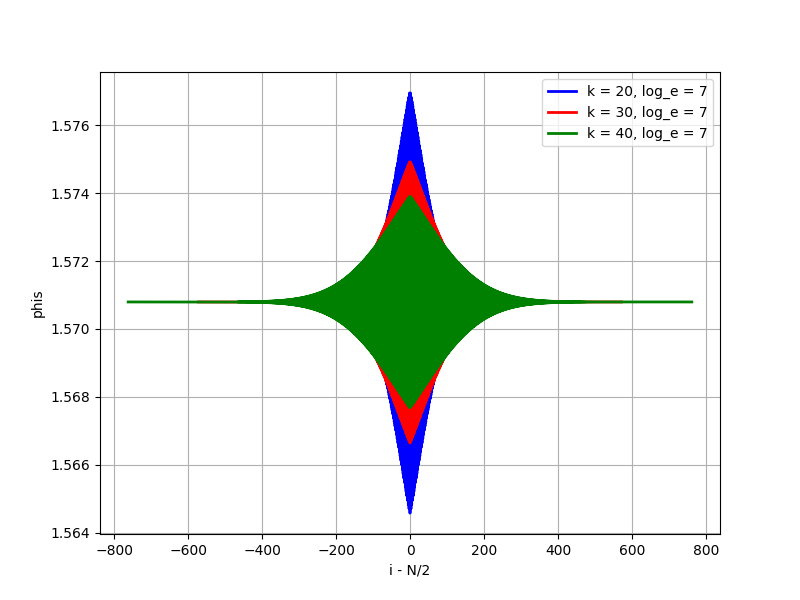

maximum difference between pos. and neg. max angles: 2.480e-04


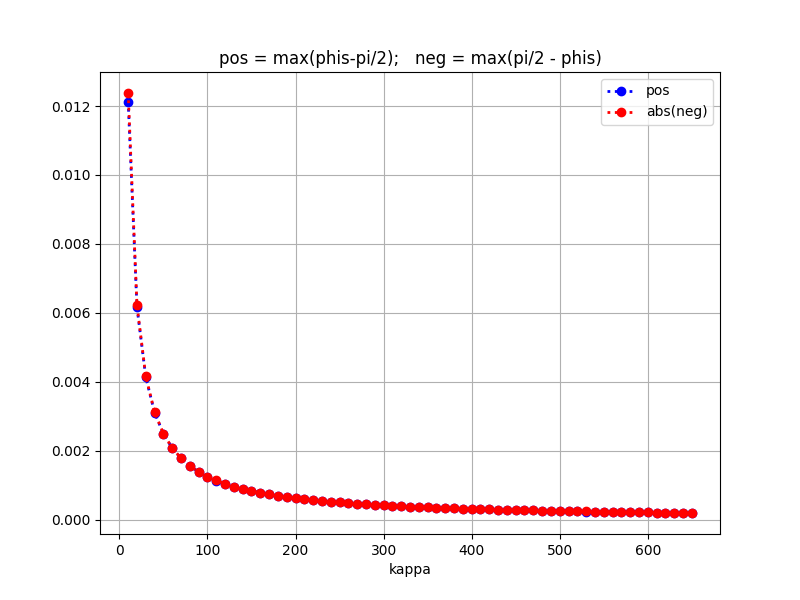

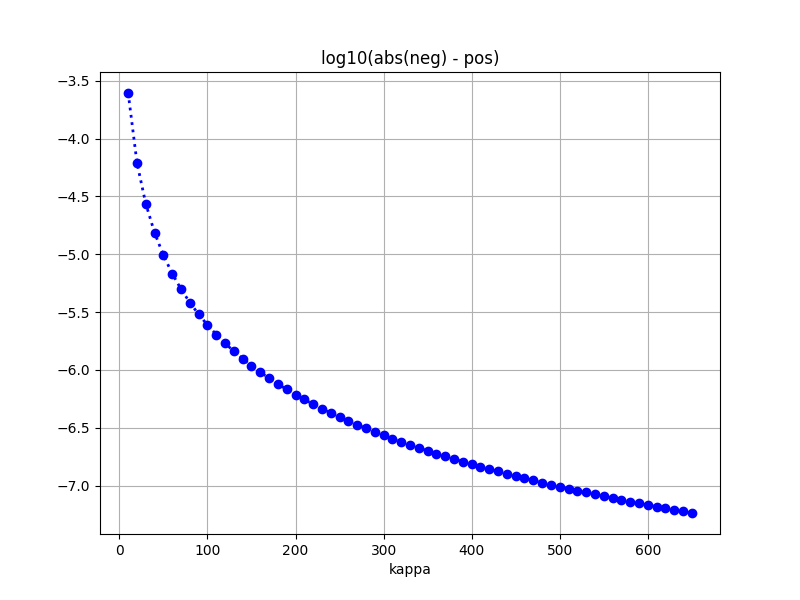

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//log_diff_pos_neg.dat


In [5]:
# -----------------------------------------
# --- PLOT angles ----
# -----------------------------------------
mix.reload_module(eqsvt)

eqsvt.plot_angles(
    dds_, 
    [1, 2, 3], 
    flag_save = True & flag_save_gl_,
    path_save_plots = path_save_plots_,
    flag_shifted = False
) 

# --- Plot maximum values of the angles ----
mix.reload_module(eqsvt)
eqsvt.plot_max(
    dds_,
    flag_save = True & flag_save_gl_,
    path_save_plots = path_save_plots_
)


--- Estimation coefs for neg amplitudes ---
max. abs. err: 5.180e-13


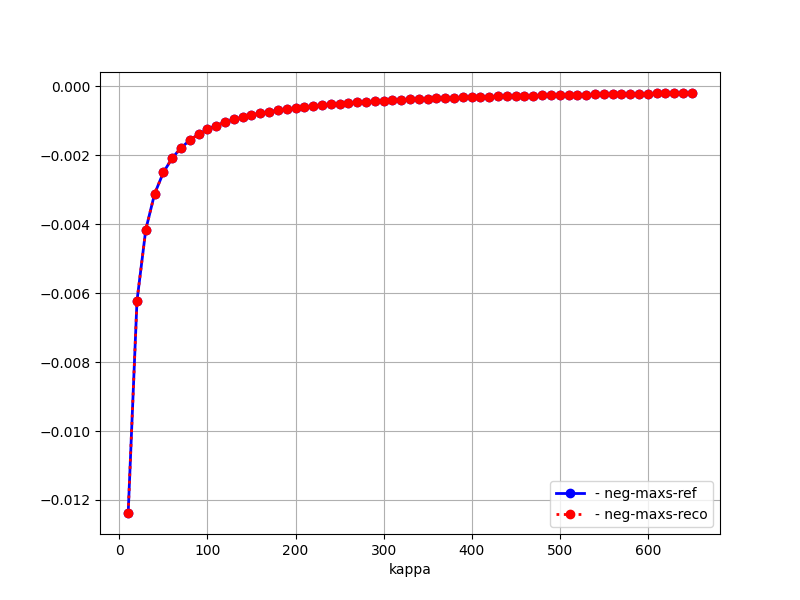


--- Estimation coefs for pos amplitudes ---
max. abs. err: 1.000e-09


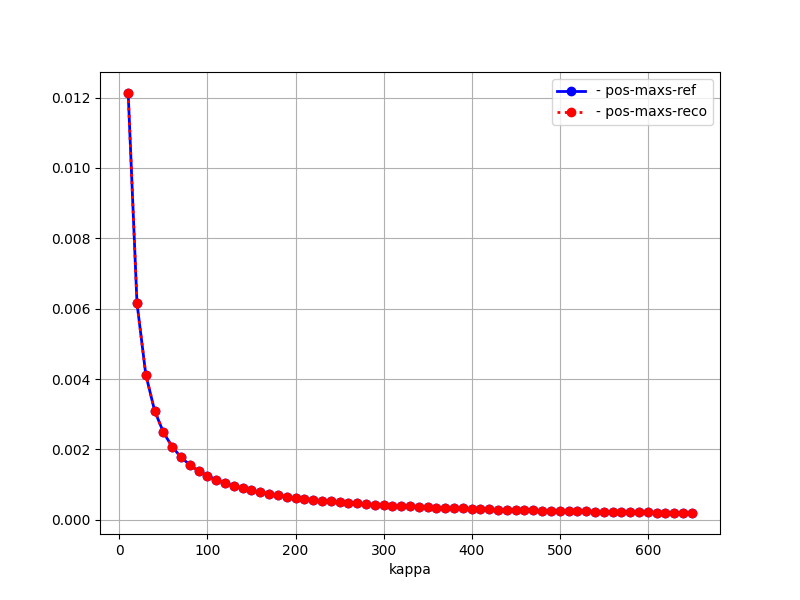

In [6]:
# -------------------------------------------------------------------------
# --- COMPUTE coefficients: angles' max & min AMPLITUDES ---
mix.reload_module(eqsvt)
coefs_ampl_neg_, coefs_ampl_pos_ = eqsvt.compute_coefs_amplitudes(
    dds_,
    Ncoefs = 4,
    flag_save = False & flag_save_gl_,
    path_save_plots = path_save_plots_
)


--- Estimation coefs for neg Na ---
max. abs. err: 1.910e+02


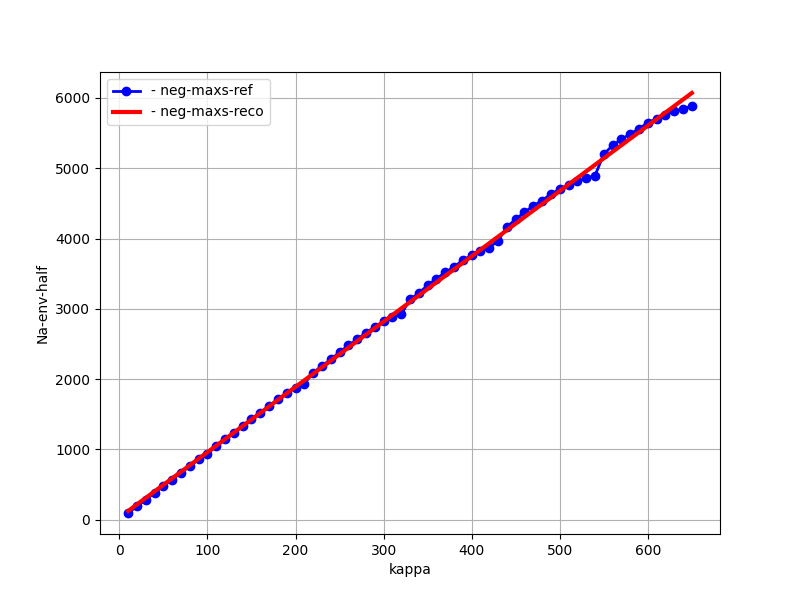


--- Estimation coefs for pos Na ---
max. abs. err: 1.910e+02


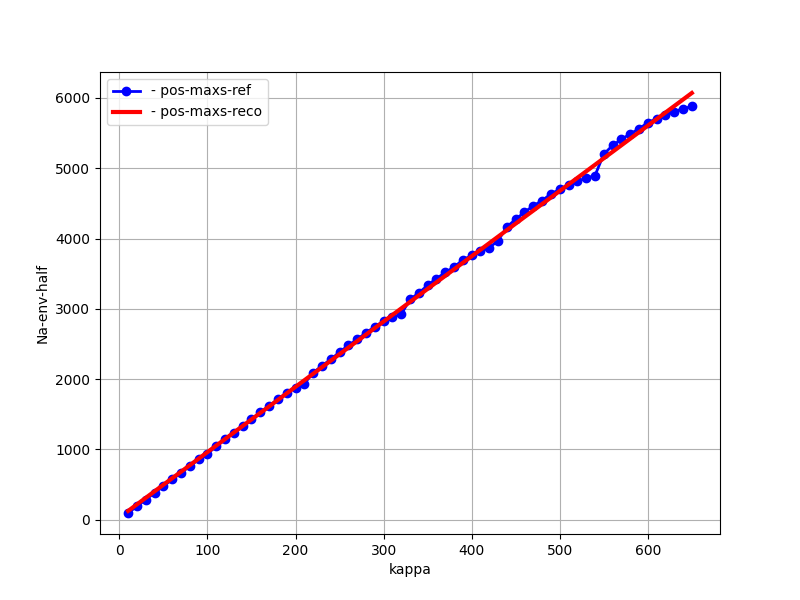

[33.013  9.289]
[32.696  9.29 ]


In [9]:
# ---------------------------------------------------------------------------------------------------
# --- COMPUTE coefficients: NUMBER of angles ---
mix.reload_module(eqsvt)
coefs_Na_neg_, coefs_Na_pos_ = eqsvt.compute_coefs_Na(
    dds_,
    Ncoefs = 2,
    flag_save = False & flag_save_gl_,
    path_save_plots = path_save_plots_
)
print(coefs_Na_neg_)
print(coefs_Na_pos_)


full number of angles: 23520
N of NEG. peaks: 11760
N of POS. peaks: 11760

N_env-half-NEG: 5880
N_env-half-POS: 5880
The envelope for the kappa = 650 is taken.


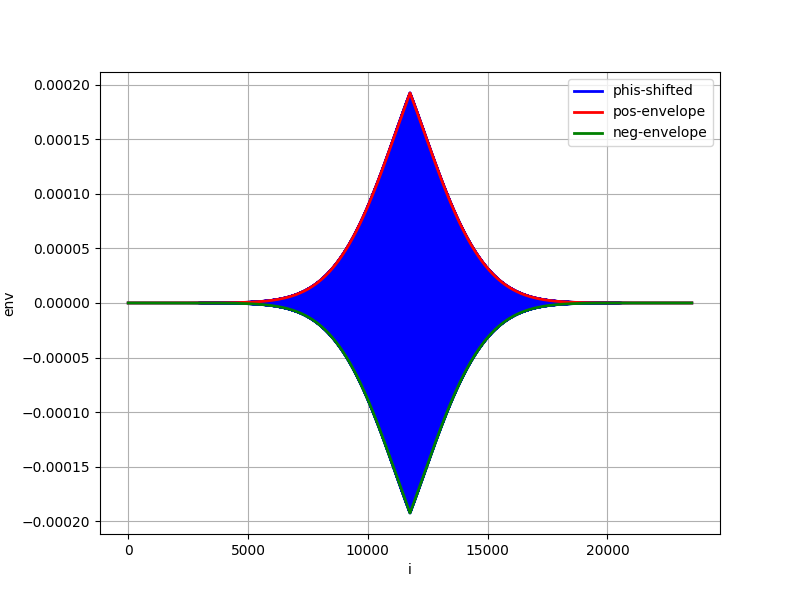

Normalized POS. ENV: max. absolute error: 8.780e-08
Normalized NEG. ENV: max. absolute error: 8.797e-08


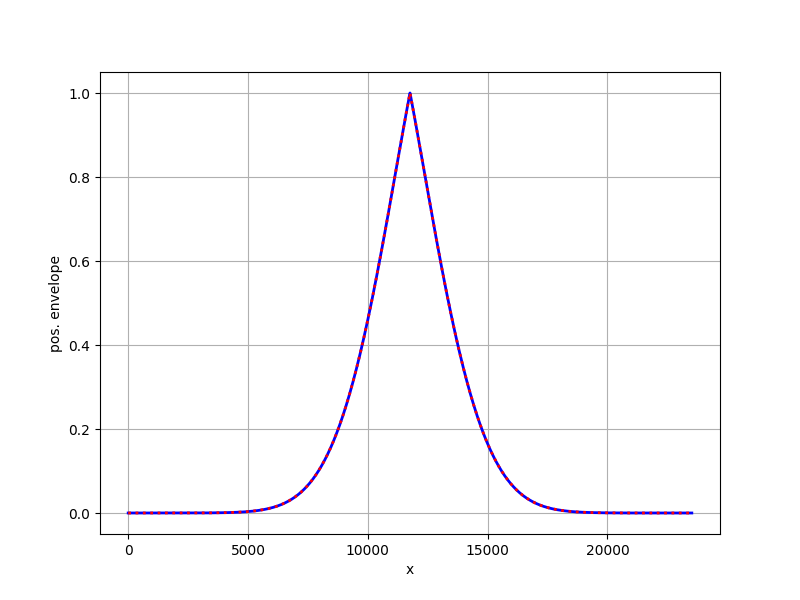

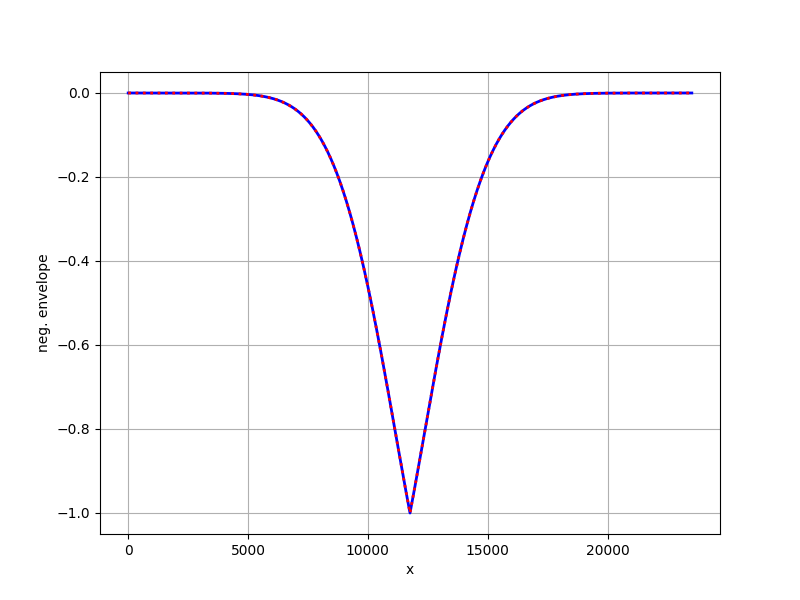



--- Reconstructing the QSVT angles for the same kappa ---
1. The envelope of the QSVT angles are approximated by the computed coefs.
2. The number of the QSVT angles and their absolute amplitudes are taken from the reference QSVT case.

max-abs-err in final reconstructed QSVT angles: 1.691e-11


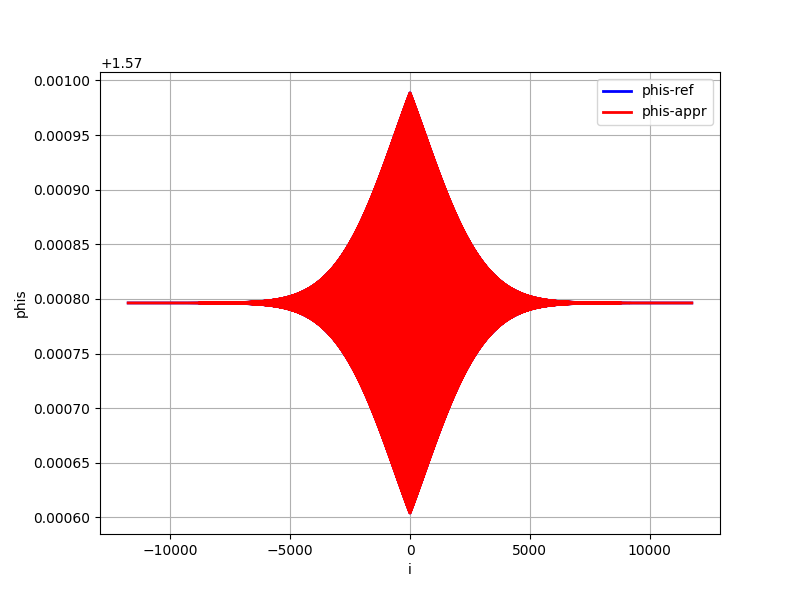

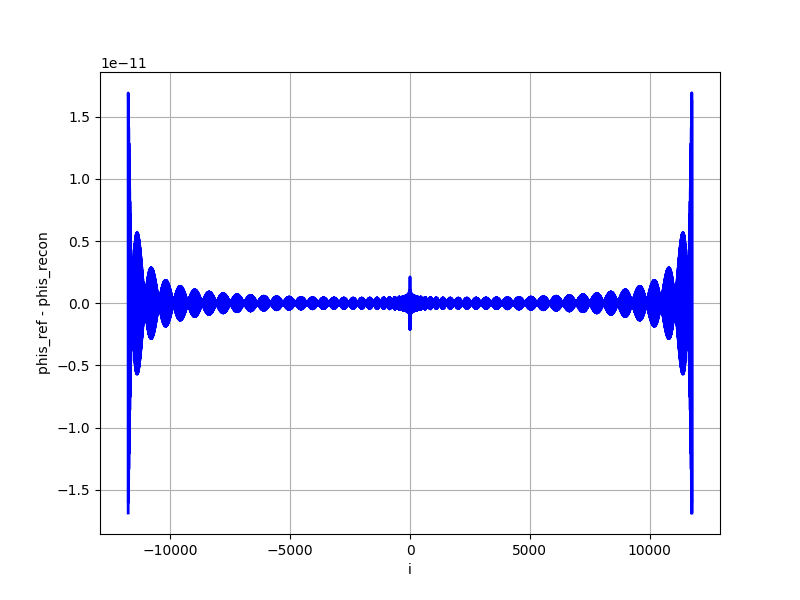

In [43]:
# ----------------------------------------------------------------------------------------
# --- COMPUTE coefficients: ENVELOP (SHAPE) of angles---
# ----------------------------------------------------------------------------------------
mix.reload_module(eqsvt)
coefs_shape_neg_, coefs_shape_pos_, N_half_env_neg_, N_half_env_pos_, phis_appr_ = \
    eqsvt.compute_coefs_envelop(
        dds_[id_comp_],
        Ncoefs = Ncoefs_, 
        flag_plot_envelop = True, 
        flag_plot_shape = True,
        flag_reconstruct = True
    )


--------------------------------------------------------------------
N-coefs = 40

full number of angles: 3200
N of NEG. peaks: 1600
N of POS. peaks: 1600

N_env-half-NEG: 800
N_env-half-POS: 800
The envelop for the kappa = 100 is taken.
Normalized POS. ENV: max. absolute error: 1.028e-06
Normalized NEG. ENV: max. absolute error: 1.039e-06

--------------------------------------------------------------------
N-coefs = 30

full number of angles: 3200
N of NEG. peaks: 1600
N of POS. peaks: 1600

N_env-half-NEG: 800
N_env-half-POS: 800
The envelop for the kappa = 100 is taken.
Normalized POS. ENV: max. absolute error: 1.364e-06
Normalized NEG. ENV: max. absolute error: 1.378e-06

--------------------------------------------------------------------
N-coefs = 20

full number of angles: 3200
N of NEG. peaks: 1600
N of POS. peaks: 1600

N_env-half-NEG: 800
N_env-half-POS: 800
The envelop for the kappa = 100 is taken.
Normalized POS. ENV: max. absolute error: 1.986e-06
Normalized NEG. ENV: ma

/media/work/docs/codes/QuCF/scripts-py/tools/est_qsvt.py:912: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(FIG_SIZE_W_,FIG_SIZE_H_))


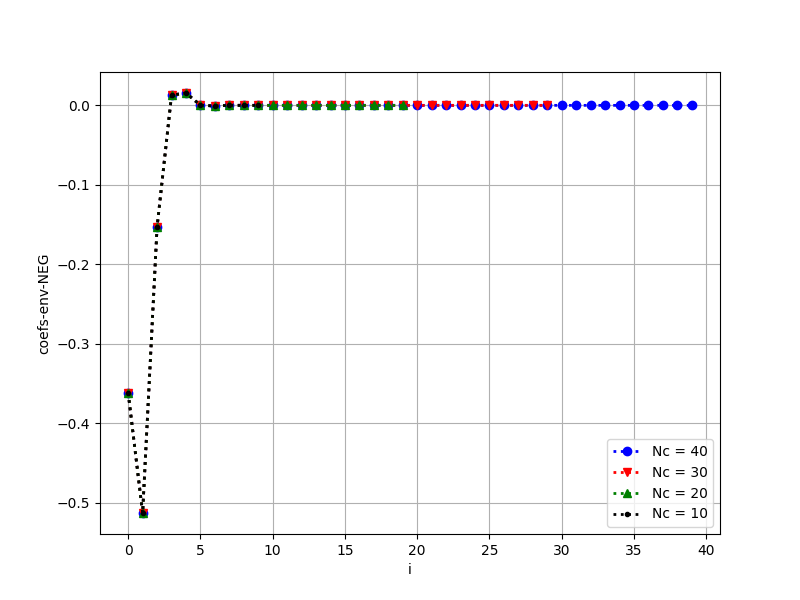

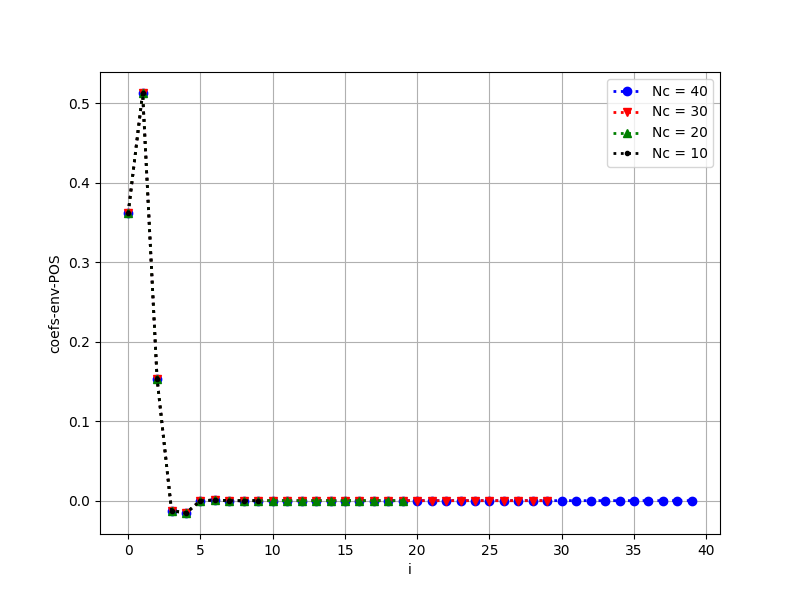

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//Ch_coefs_pos_Nc40.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//Ch_coefs_pos_Nc30.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//Ch_coefs_pos_Nc20.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//Ch_coefs_pos_Nc10.dat


In [10]:
# ------------------------------------------------------
# --- PLOT the coefficients for the envelop ---
# ------------------------------------------------------
mix.reload_module(eqsvt)
eqsvt.plot_env_coefs(
    dds_[id_comp_], 
    Ncoefs_arrs = [40, 30, 20, 10],
    flag_save = True & flag_save_gl_,
    path_save_plots = path_save_plots_
)

In [7]:
# ----------------------------------------------------------------------------------------
# --- SAVE the computed coefficients ---
# ----------------------------------------------------------------------------------------
mix.reload_module(eqsvt)
eqsvt.store_estimation(
    dds_[id_comp_], fname_, path_root_,
    coefs_ampl_neg_, coefs_ampl_pos_,
    coefs_Na_neg_, coefs_Na_pos_,
    coefs_shape_neg_, coefs_shape_pos_,
    N_half_env_neg_, N_half_env_pos_
)

Storing the coefficients to:
 ./tools/QSVT-angles/inversion//QSVT-MI-estimation-coefs-case6-Nc40.hdf5



--- Estimating the QSVT angles. ---
N-reconstructed-angles: 30133332
Done.
N-angles: 30133332
kappa: 800000.0
coef-norm: 1.250e-01

max. angle - np.pi/2: 1.557e-07
min. angle - np.pi/2: -1.562e-07


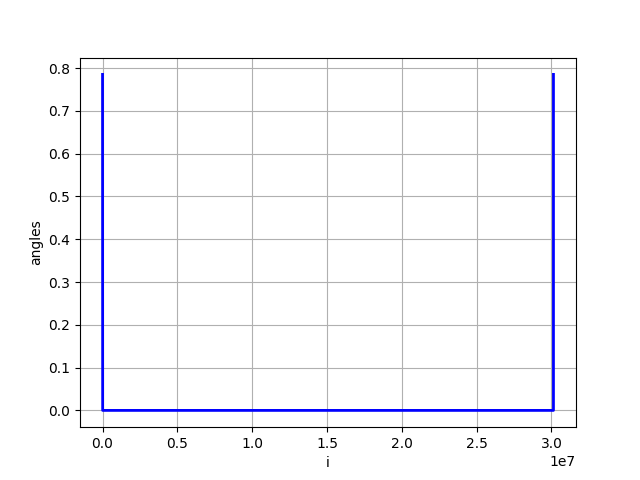

[-1.000e-05 -9.913e-06 -9.825e-06 -9.738e-06 -9.650e-06 -9.563e-06
 -9.475e-06 -9.388e-06 -9.300e-06 -9.213e-06 -9.125e-06 -9.038e-06
 -8.950e-06 -8.863e-06 -8.775e-06 -8.688e-06 -8.600e-06 -8.513e-06
 -8.425e-06 -8.338e-06 -8.250e-06 -8.163e-06 -8.075e-06 -7.988e-06
 -7.900e-06 -7.813e-06 -7.725e-06 -7.638e-06 -7.550e-06 -7.463e-06
 -7.375e-06 -7.288e-06 -7.200e-06 -7.113e-06 -7.025e-06 -6.938e-06
 -6.850e-06 -6.763e-06 -6.675e-06 -6.588e-06 -6.500e-06 -6.413e-06
 -6.325e-06 -6.238e-06 -6.150e-06 -6.062e-06 -5.975e-06 -5.888e-06
 -5.800e-06 -5.712e-06 -5.625e-06 -5.538e-06 -5.450e-06 -5.362e-06
 -5.275e-06 -5.188e-06 -5.100e-06 -5.012e-06 -4.925e-06 -4.838e-06
 -4.750e-06 -4.662e-06 -4.575e-06 -4.488e-06 -4.400e-06 -4.312e-06
 -4.225e-06 -4.138e-06 -4.050e-06 -3.962e-06 -3.875e-06 -3.788e-06
 -3.700e-06 -3.612e-06 -3.525e-06 -3.438e-06 -3.350e-06 -3.262e-06
 -3.175e-06 -3.088e-06 -3.000e-06 -2.912e-06 -2.825e-06 -2.738e-06
 -2.650e-06 -2.562e-06 -2.475e-06 -2.388e-06 -2.300e-06 -2.212

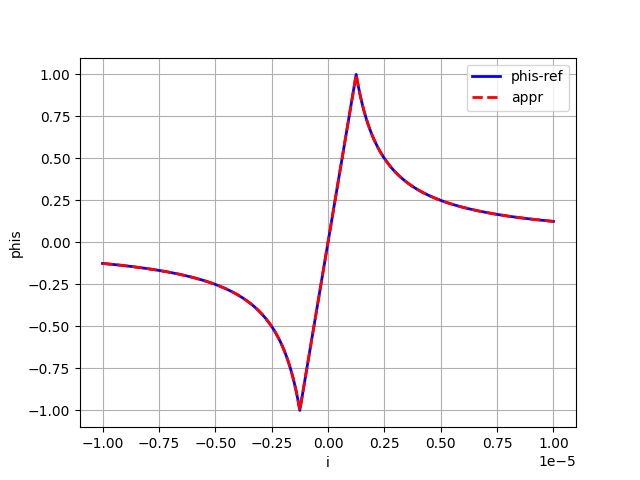

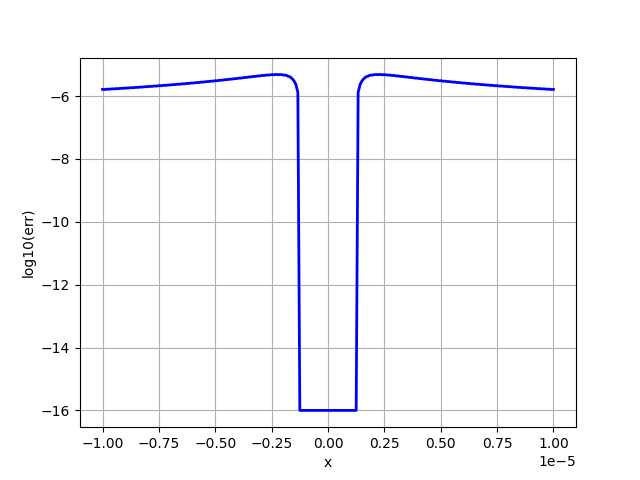

Done.


In [39]:
# ------------------------------------------------------------------
# --- Construct 1/x function for an arbitrary kappa ---
# ------------------------------------------------------------------
mix.reload_module(eqsvt)
def reco_inv_x(
    kappa_target, 
    flag_extrapolation_env, 
    fname_save = None,
    opt_domain = None
):
    dd = {}
    if flag_extrapolation_env:
        coefs_env_neg, coefs_env_pos = eqsvt.extrapolate_CEs(
            kappa_target, cns_, cps_, kappas_
        )
        dd["coefs-env-neg"] = coefs_env_neg
        dd["coefs-env-pos"] = coefs_env_pos
    else:
        dd["coefs-env-neg"] = coefs_shape_neg_
        dd["coefs-env-pos"] = coefs_shape_pos_
        dd["N-env-half-neg"] = N_half_env_neg_, 
        dd["N-env-half-pos"] = N_half_env_pos_
        dd["kappa"] = dds_[id_comp_]['function-parameter']
    dd["coefs-Na-neg"] = coefs_Na_neg_
    dd["coefs-Na-pos"] = coefs_Na_pos_
    dd["coefs-ampl-neg"] = coefs_ampl_neg_
    dd["coefs-ampl-pos"] = coefs_ampl_pos_
    dd["factor-norm"] = dds_[0]["factor-norm"]

    print()
    print("--- Estimating the QSVT angles. ---")
    phis_appr_, coef_norm_ = eqsvt.estimate_angles(dd, kappa_target)

    eqsvt.construct_inverse_function_GPU(
        phis_appr_,
        kappa     = kappa_target, 
        coef_norm = coef_norm_,
        opt_domain = opt_domain,
        flag_save = False & flag_save_gl_,
        path_save_ = path_save_plots_,
        fname_save = fname_save
    )
    print("Done.")
    return
# ---------------------------------------------------------
# kappa_target, opt_domain = 100, 0
# kappa_target, opt_domain = 1000, 0
# kappa_target, opt_domain = 10000, 0

# kappa_target, opt_domain = 1e2, 2
# kappa_target, opt_domain = 1e3, 2
# kappa_target, opt_domain = 5e3, 2
# kappa_target, opt_domain = 1e4, 2
# kappa_target, opt_domain = 5e4, 2
# kappa_target, opt_domain = 1e5, 2
# kappa_target, opt_domain = 5e5, 2
# kappa_target, opt_domain = 8e5, 2
# kappa_target, opt_domain = 1e6, 2
# kappa_target, opt_domain = 2e6, 2
# kappa_target, opt_domain = 5e6, 2

fname_save = "k{:d}_x{:d}".format(int(kappa_target), opt_domain)
reco_inv_x(
    kappa_target = kappa_target, 
    flag_extrapolation_env = False, 
    fname_save = fname_save,
    opt_domain = opt_domain
)
del fname_save

In [41]:
# -------------------------------------------------
# --- Scan: eps versus kappa ---
# -------------------------------------------------
def scan_kappa():

    # --- case = 6, Nc = 20 ---
    kappa_array = \
    [      
              1e2,       1e3,       5e3,       1e4,       5e4,       
              1e5,       5e5,       8e5,       
              1e6,       2e6,       5e6
    ]
    error_array = \
    [
        3.389e-05, 2.042e-06, 5.204e-06, 5.493e-06, 5.272e-06, 
        4.630e-06, 8.765e-07, 4.917e-06,
        7.617e-06, 2.109e-05, 6.140e-05,
    ]

    log_kappa = np.log10(kappa_array)
    log_err = np.log10(error_array)

    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/direct_scan_err_Nc20.dat", 
        log_kappa, log_err
    )
    return
# --------------------------
scan_kappa()
del scan_kappa

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//direct_scan_err_Nc20.dat


N-angles: 22600
kappa: 600.0
coef-norm: 1.250e-01

max. angle - np.pi/2: 2.082e-04
min. angle - np.pi/2: -2.083e-04


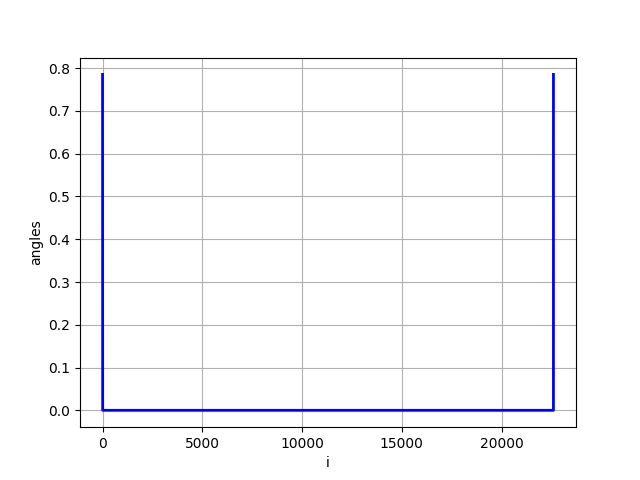

max-abs-err: 1.346e-08


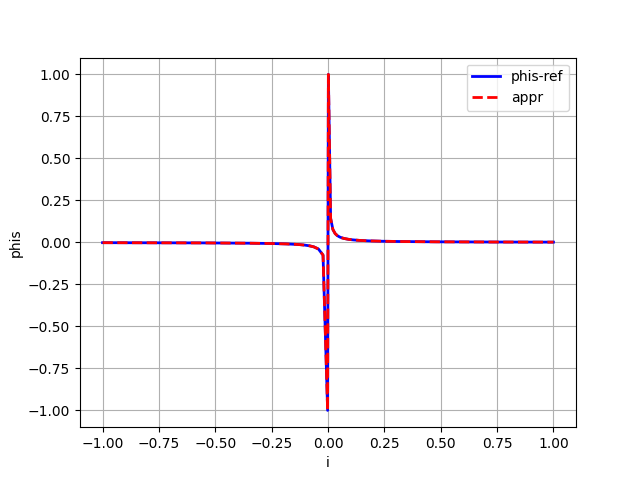

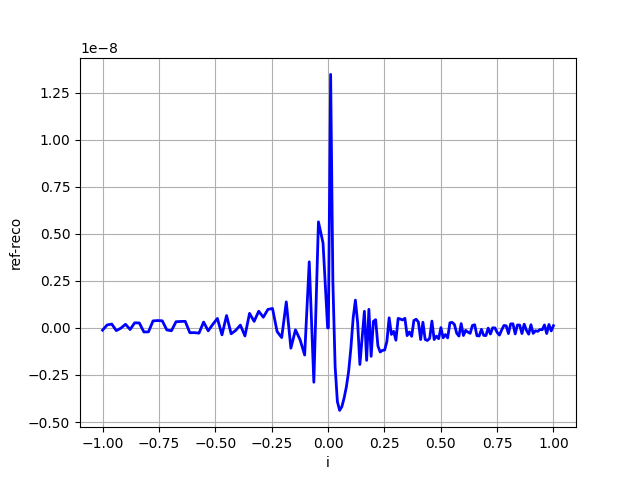

In [13]:
# -------------------------------------------------------
# --- Compute 1/x using a sequence of rotations ---
# -------------------------------------------------------
mix.reload_module(eqsvt)

phi_comp = np.array(phis_appr_)
# phi_comp = np.array(dds_[id_comp_]["phis"])

# padding_array = np.array([np.pi/2.] * 10001)
# phi_comp = np.concatenate(
#     (padding_array, phi_comp, padding_array)
# )

eqsvt.construct_inverse_function(
    phi_comp,
    kappa = dds_[id_comp_]["function-parameter"], 
    coef_norm = dds_[id_comp_]["factor-norm"]
)

In [5]:
# ---------------------------------------------------------------------------------------------
# --- Compute coefficients-envelop (CEs) for various reference kappa ---
# ---------------------------------------------------------------------------------------------
mix.reload_module(eqsvt)
cns_, cps_, kappas_ = eqsvt.compute_coefs_var_kappa(
    dds_, 
    Ncoefs = Ncoefs_
)



full number of angles: 382
N of NEG. peaks: 192
N of POS. peaks: 190

N_env-half-NEG: 96
N_env-half-POS: 95
The envelope for the kappa = 10 is taken.
Normalized POS. ENV: max. absolute error: 3.225e-08
Normalized NEG. ENV: max. absolute error: 2.743e-08

full number of angles: 762
N of NEG. peaks: 382
N of POS. peaks: 380

N_env-half-NEG: 191
N_env-half-POS: 190
The envelope for the kappa = 20 is taken.
Normalized POS. ENV: max. absolute error: 3.264e-08
Normalized NEG. ENV: max. absolute error: 3.009e-08

full number of angles: 1144
N of NEG. peaks: 572
N of POS. peaks: 572

N_env-half-NEG: 286
N_env-half-POS: 286
The envelope for the kappa = 30 is taken.
Normalized POS. ENV: max. absolute error: 2.970e-08
Normalized NEG. ENV: max. absolute error: 3.103e-08

full number of angles: 1524
N of NEG. peaks: 762
N of POS. peaks: 762

N_env-half-NEG: 381
N_env-half-POS: 381
The envelope for the kappa = 40 is taken.
Normalized POS. ENV: max. absolute error: 3.052e-08
Normalized NEG. ENV: max

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_POS_env_kappa_c0.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_POS_env_kappa_c1.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_POS_env_kappa_c2.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_POS_env_kappa_c3.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_POS_env_kappa_c4.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_POS_env_kappa_c5.dat


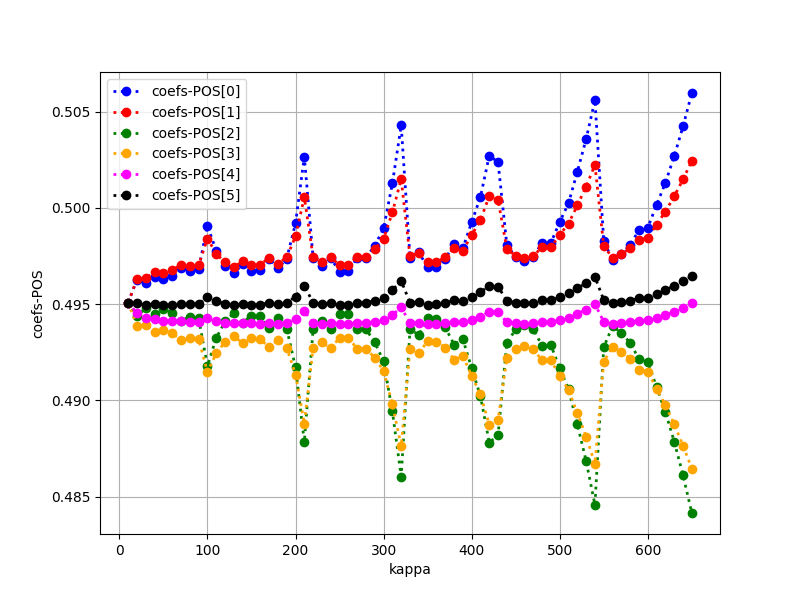

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_NEG_env_kappa_c0.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_NEG_env_kappa_c1.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_NEG_env_kappa_c2.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_NEG_env_kappa_c3.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_NEG_env_kappa_c4.dat
write data to a file: ./tools/QSVT-angles/inversion//saved-plots//coefs_NEG_env_kappa_c5.dat


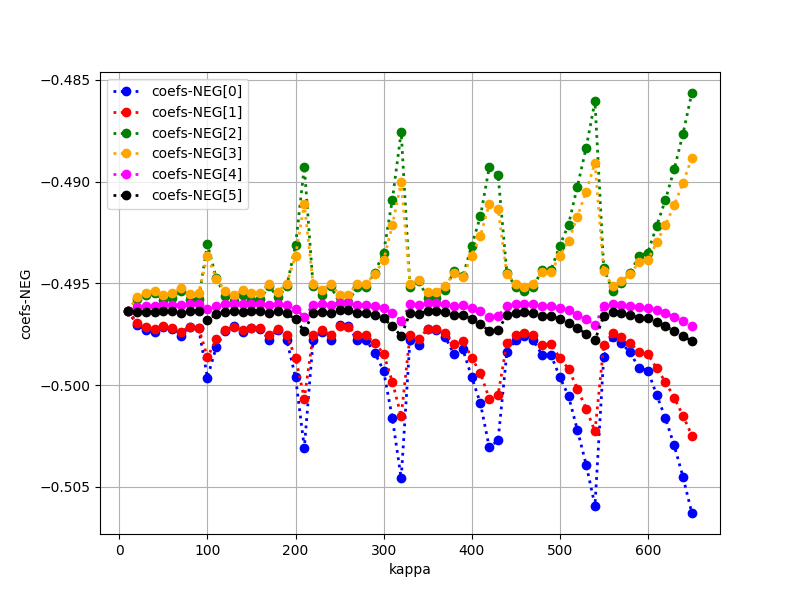

In [31]:

# ---------------------------------------------------------------------------------------------
# --- PLOT CEs for various reference kappa ---
# ---------------------------------------------------------------------------------------------
mix.reload_module(eqsvt)
eqsvt.plot_coefs_var_kappa(
    cns_, cps_, kappas_,
    ids_ch_coef = [0,1,2,3,4,5], # which coefficients to plot;
    path_save_plots = path_save_plots_,
    flag_save = True,
    flag_shifted=False
)

In [4]:
# ---------------------------------------------------------------------------------
# --- Reconstruct CEs for a particular kappa (just interpolation) ---
# ---------------------------------------------------------------------------------
mix.reload_module(eqsvt)
eqsvt.reconstruct_CEs_kappa(1, dds_, cns_, cps_, kappas_)

NameError: name 'cns_' is not defined

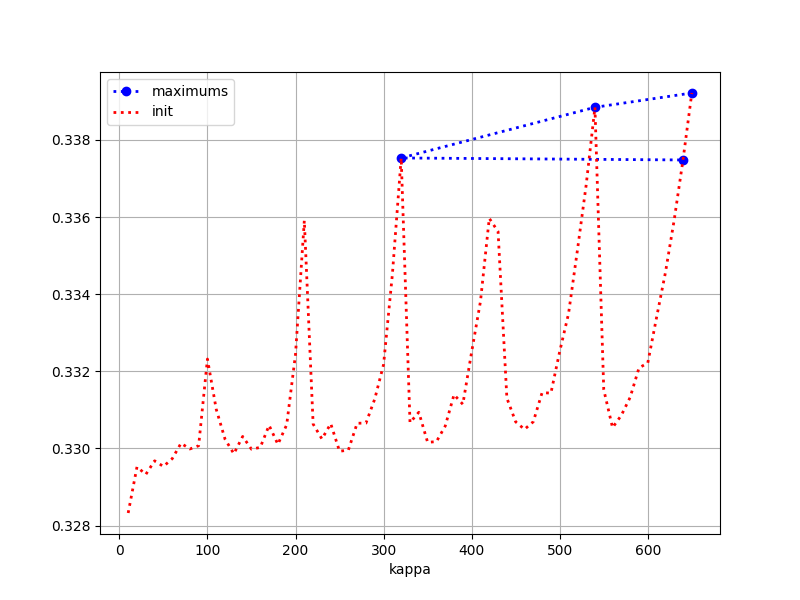

In [52]:
# ---------------------------------------------------------------------------------
# --- Approximate the dependence of each CE on kappa by a Chebyschev series ---
# ---------------------------------------------------------------------------------
mix.reload_module(eqsvt)

Ncoefs_coefs_ = 2

ccns_, ccps_ = eqsvt.compute_env_coefs_dependence_kappa(
    Ncoefs_coefs_, cns_, cps_, kappas_,
    flag_reco = True
)

------------------
Chosen kappa: 60.0
Na: 4156
ref: N-neg: 2078
ref: N-pos: 2078
------------------
Reading the coefficients from:
 ./tools/QSVT-angles/inversion//QSVT-MI-estimation-coefs-case3-Nc40.hdf5
When simulated:  02/08/2024: 14:50:39
Data for-inversion
kappa: 80.000
factor-norm: 0.125
N-env-half-neg: 1483
N-env-half-pos: 1482
N-coefs-envelop-neg: 40
N-coefs-envelop-pos: 40
Na_rec-rec: 4156
Done.
N-ref: 4156
N-rec: 4156

diff in max, min: -9.260e-12, 4.707e-14
max. abs. err: 7.097e-05


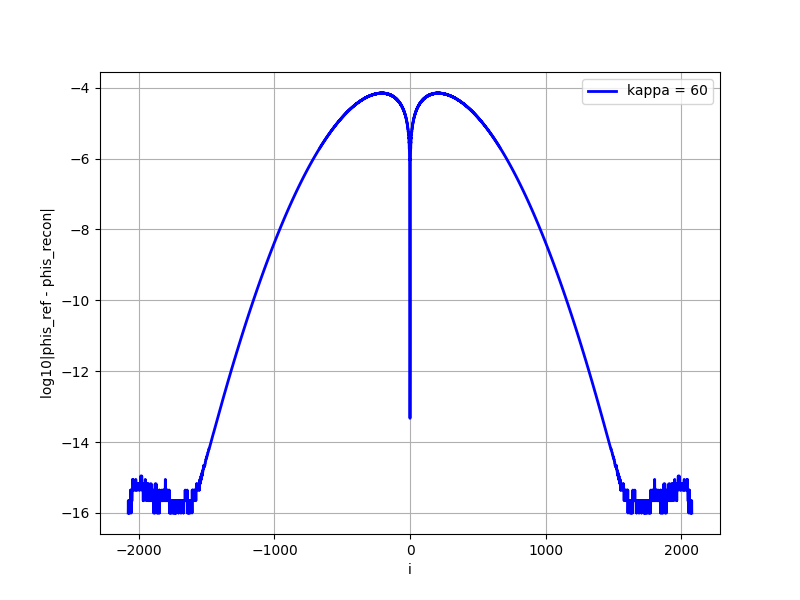

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//env_err_k60.dat
------------------
Chosen kappa: 80.0
Na: 5930
ref: N-neg: 2966
ref: N-pos: 2964
------------------
Reading the coefficients from:
 ./tools/QSVT-angles/inversion//QSVT-MI-estimation-coefs-case3-Nc40.hdf5
When simulated:  02/08/2024: 14:50:39
Data for-inversion
kappa: 80.000
factor-norm: 0.125
N-env-half-neg: 1483
N-env-half-pos: 1482
N-coefs-envelop-neg: 40
N-coefs-envelop-pos: 40
Na_rec-rec: 5930
Done.
N-ref: 5930
N-rec: 5930

diff in max, min: 7.811e-12, 1.710e-14
max. abs. err: 7.811e-12


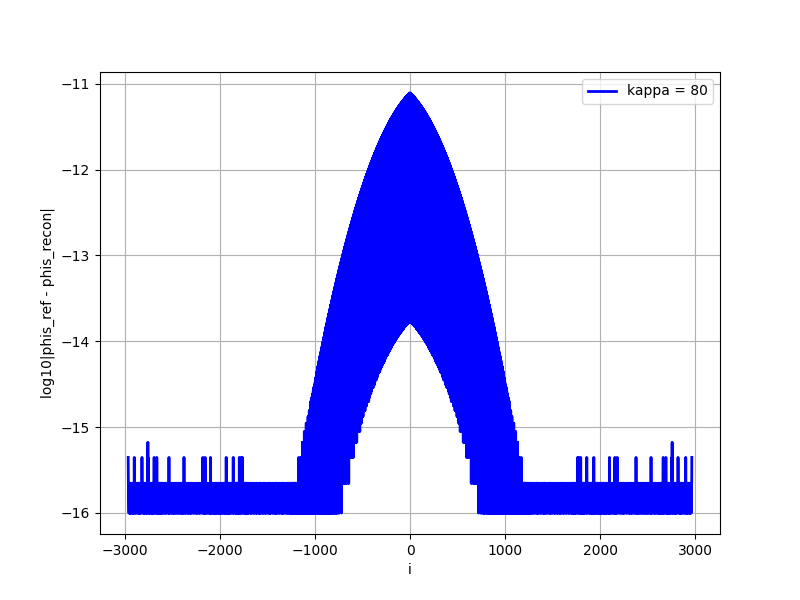

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//env_err_k80.dat
------------------
Chosen kappa: 100.0
Na: 7794
ref: N-neg: 3898
ref: N-pos: 3896
------------------
Reading the coefficients from:
 ./tools/QSVT-angles/inversion//QSVT-MI-estimation-coefs-case3-Nc40.hdf5
When simulated:  02/08/2024: 14:50:39
Data for-inversion
kappa: 80.000
factor-norm: 0.125
N-env-half-neg: 1483
N-env-half-pos: 1482
N-coefs-envelop-neg: 40
N-coefs-envelop-pos: 40
Na_rec-rec: 7794
Done.
N-ref: 7794
N-rec: 7794

diff in max, min: 6.044e-12, -9.326e-15
max. abs. err: 3.134e-05


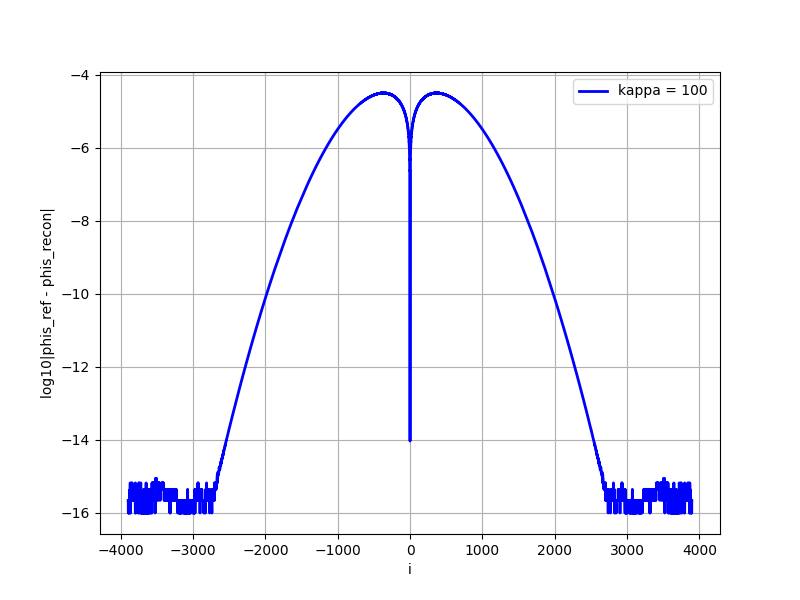

write data to a file: ./tools/QSVT-angles/inversion//saved-plots//env_err_k100.dat


In [4]:
# ---------------------------------------------------------------------------------------------
# --- Compare the reference QSVT angles and the reconstructed angles ---
# ---------------------------------------------------------------------------------------------
# Here the QSVT angles are reconstructed without using any parameters from the reference case.
mix.reload_module(eqsvt)

def compare_reconstructed_and_known_angles(dds, ids_ch, flag_save, path_save_plots):
    def compare_angles(phis_ref, phis_rec):
        phis_ch = np.array(phis_ref)

        print("N-ref: {:d}".format(len(phis_ref)))
        print("N-rec: {:d}".format(len(phis_rec)))

        print()
        print("diff in max, min: {:0.3e}, {:0.3e}".format(
            np.max(phis_rec) - np.max(phis_ref),
            np.min(phis_rec) - np.min(phis_ref),
        ))

        max_abs_err = np.max(np.abs(phis_ch - phis_rec))
        print("max. abs. err: {:0.3e}".format(max_abs_err))
        return
    # -------------------------------------------------------------------------

    for id_ch in ids_ch:
        kappa_ch = dds[id_ch]["function-parameter"]
        phis_ref = np.array(dds[id_ch]["phis"])
        Na = len(dds[id_ch]["phis"])

        temp = eqsvt.extract_env(
            np.array(phis_ref- np.pi/2.),
            np.mod(Na//2,2)
        )

        N_neg = len(temp["neg-i"])
        N_pos = len(temp["pos-i"])

        print("------------------")
        print("Chosen kappa: {:0.1f}".format(kappa_ch))
        print("Na: {:d}".format(Na))
        print("ref: N-neg: {:d}".format(N_neg))
        print("ref: N-pos: {:d}".format(N_pos))
        print("------------------")

        Nh_neg = N_neg//2
        if(np.mod(N_neg, 2) == 1):
            Nh_neg += 1
            

        phis_appr_fully, _ = eqsvt.estimate_angles(
            eqsvt.read_estimation(id_case_, Ncoefs_), 
            kappa_goal = kappa_ch,
            # # --- comment to compute the actual number of the QSVT estimated angles ---
            Nh_neg_ref = Nh_neg,
            Nh_pos_ref = N_pos//2
        )

        # --- Compare angles ---
        compare_angles(phis_ref, phis_appr_fully)

        # --- Compute the difference ---
        array_ids =  np.array(range(Na)) - Na//2
        log_diff = np.zeros(Na)
        for ii in range(Na):
            temp = np.abs(phis_appr_fully[ii] - phis_ref[ii])
            if temp <= 1e-16:
                temp = 1e-16
            log_diff[ii] = np.log10(temp)

        # --- Plot the difference ---
        fig = plt.figure(figsize=(eqsvt.FIG_SIZE_W_,eqsvt.FIG_SIZE_H_))
        ax = fig.add_subplot(111)
        ax.plot(
            array_ids, 
            log_diff, 
            color="b", linewidth = 2, linestyle='-', 
            label = "kappa = {:d}".format(int(kappa_ch))
        )
        plt.xlabel('i')
        plt.ylabel("log10|phis_ref - phis_recon|")
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- Saving data ---
        if flag_save_gl_:
            mix.save_dat_plot_1d_file(
                path_save_plots + "/env_err_k{:d}.dat".format(int(kappa_ch)), 
                array_ids, 
                log_diff
            )
# --------------------------------------------------------------

compare_reconstructed_and_known_angles(
    dds_,
    ids_ch = [2, 3, 4],
    flag_save = True & flag_save_gl_, 
    path_save_plots = path_save_plots_
)   